In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import PrettyPrinter

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, Concatenate
from tensorflow.python.keras.callbacks import ModelCheckpoint

%matplotlib inline

pp = PrettyPrinter()

C:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

def one_hot_encode(text_index_lists, max_n):
    texts = []
    for idx1, text_index_list in enumerate(text_index_lists):
        text = np.zeros((len(text_index_list), max_n))
        for idx2, index in enumerate(text_index_list):
            text[idx2, index - 1] = 1
        texts.append(text)
    return texts

# dataset
ds_x = [
    'he is a good man',
    'you are a smart woman',
    'she is a bad woman',
    'a bad man',
    'an idiot man he is',
    'is he an idiot',
    'he is an idiot man',
    'you are a good man',
    'you are a smart man',
    'she is a good woman',
    'you are bad',
    'he is good',
    'she is an idiot woman',
    'he is a smart man'
]
# 1: good, 0: bad
ds_y = [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0 ,1]

# fit tokenizer to get list of indexes to one-hot encode and act as word embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(ds_x)

#max length of word embeddings
embeddings_l = len(tokenizer.word_counts)
print('Length of word embeddings: %d' % embeddings_l, '\n\n')

# list of indexes
list_of_indexes = tokenizer.texts_to_sequences(ds_x)
print('list of indexes')
pp.pprint(list_of_indexes)

# one-hot encode
ds_X = one_hot_encode(list_of_indexes, embeddings_l)
print('One hot encoded')
pp.pprint(ds_X)

#pad sequences for max length of sentence
ds_X = pad_sequences(ds_X, padding='post')
print('After padding')
pp.pprint(ds_X)

max_sequence_length = len(ds_X[0])


Length of word embeddings: 13 


list of indexes
[[4, 1, 2, 5, 3],
 [6, 7, 2, 11, 8],
 [12, 1, 2, 13, 8],
 [2, 13, 3],
 [9, 10, 3, 4, 1],
 [1, 4, 9, 10],
 [4, 1, 9, 10, 3],
 [6, 7, 2, 5, 3],
 [6, 7, 2, 11, 3],
 [12, 1, 2, 5, 8],
 [6, 7, 13],
 [4, 1, 5],
 [12, 1, 9, 10, 8],
 [4, 1, 2, 11, 3]]
One hot encoded
[array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0

In [3]:
X = np.array(ds_X)
X = X.reshape(-1, X.shape[-2], X.shape[-1], 1)
y = np.array(ds_y)
X_train = X[:-4]
y_train = y[:-4]
X_test = X[-4:]
y_test = y[-4:]
max_sequence_length, embeddings_length = X_train.shape[1:3]
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (10, 5, 13, 1)
y_train shape:  (10,)
X_test shape:  (4, 5, 13, 1)
y_test shape:  (4,)


In [4]:
def n_grams_channel(inputs, n):
    channel = Conv2D(1, kernel_size=(n, embeddings_length), activation='relu')(inputs)
    channel_mp = MaxPool2D(pool_size=(channel.shape[1], 1))(channel)
    channel_final = Flatten()(channel_mp)        
    return channel_final

In [5]:
inputs = Input(shape=(max_sequence_length, embeddings_length, 1))
channel1_final = n_grams_channel(inputs, 2)
channel2_final = n_grams_channel(inputs, 3)
channel3_final = n_grams_channel(inputs, 4)
channels_final = Concatenate()([channel1_final, channel2_final, channel3_final])
predictions = Dense(1, 'sigmoid')(channels_final)

model = Model(inputs=inputs, outputs=predictions)

callbacks = [
    ModelCheckpoint(
        filepath='weights-improvement-{epoch:02d}-{loss:.2f}.hdf5',
        monitor='loss',
        mode='min',
        verbose=False,
        save_best_only=False,
        save_weights_only=True,
    )
]

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
)

In [6]:
history = model.fit(
    X_train, y_train,
    epochs=10000,
    verbose=False,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
)

4/4 [==============================]4/4 [==============================] - 0s 0us/step

Label: 0.000000, Prediction: 0.114810
Label: 1.000000, Prediction: 0.848187
Label: 0.000000, Prediction: 0.000013
Label: 1.000000, Prediction: 0.945456
Score: 0.085677


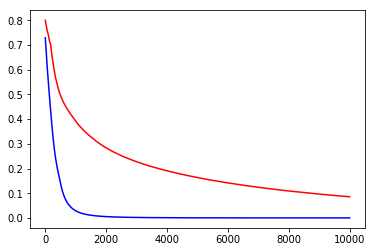

In [7]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test)
for idx in range(len(y_pred)):
    print('Label: %f, Prediction: %f' % (y_test[idx], y_pred[idx]))
print('Score: %f' % score)
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')